In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.color
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

DATA_PATH = 'GeneratedData/train/'
IDS = np.loadtxt(DATA_PATH + '/Directory.txt').astype(int)

Using TensorFlow backend.


In [2]:
print("ids: " + str(IDS))

ids: [264842443 264842516 264842563 ... 264877171 264877207 264877283]


## Configurations

In [3]:
class SonarConfig(Config):
    """
    Configuration for training on the sonar dataset.
    Derives from the base Config class and ovverrides values specific to the sonar dataset.
    """
    
    # Give configuration a recognizable name
    NAME = "sonar"

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number if classes (including background)
    NUM_CLASSES = 1 + 1    # background + target
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 30

config = SonarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                  

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Pulls data from AcousticModel simulator that includes:

* `ImageMap-<id>`: 25 image planes with each being 64x64 image w/ value 0-255`
* `LabelMap-<id>`: single 64x64 image that is 1 or 0 for target or no target respectively across all planes

Extend the Dataset class and add a method to load the sonar dataset, `load_sonar_images()`, and override the following methods:

* `load_image()`
* `load_mask()`

In [5]:
class SonarDataset(utils.Dataset):
    
    def __init__(self, class_map=None):
        """Extend __init__ parent class"""
        
        super(SonarDataset, self).__init__(class_map)
        
        # Load image tag ids
        # TODO: more portable
        self.ids = IDS
        
        # Add data path
        # TODO: more portable
        self.data_path = DATA_PATH
    
    def load_sonar(self, mode, train_size):
        """Loads sonar images (w/ masks aka labels)"""
    
        # Add class
        self.add_class("sonar", 1, "target")
        
        # Calculate split
        subset = []
        split_index = int(train_size * len(self.ids))
        image_indeces = np.arange(len(self.ids))
        if mode == "train":
            subset = image_indeces[:split_index]
        elif mode == "test":
            subset = image_indeces[split_index:]
        else:
            print("Error: specify mode")
            
        # Add images (w/ masks)
        # TODO: more portable
        for _,image_index in enumerate(subset):
            
            # Get the id tagged to the image
            id = self.ids[image_index]
                        
            # Number of instances in label (only target)
            # TODO: fix hardcode
            class_ids = np.array([1])
            
            # Get image of size 25x64x64
            img = np.fromfile(DATA_PATH + 'ImageMap-' + str(id) + '.dat',
                       dtype='uint8')
            img.shape = (25,64,64)

            # Get mask of size 64x64
            mask = np.fromfile(DATA_PATH + 'LabelMap-' + str(id) + '.dat',
                       dtype='uint8')
            mask.shape = (64, 64, 1)
            mask = mask.astype(np.bool)

            # Add image
            # ISSUE: doesn't know the difference between each 25 layered image
            for i in range(img.shape[0]):
                self.add_image("sonar", 
                               image_id=id, 
                               path=None, 
                               width=img.shape[0], 
                               height=img.shape[1],
                               # Convert from [height, width] to [height, width, 3]
                               image=skimage.color.gray2rgb(img[i]), 
                               mask=mask, 
                               class_ids=class_ids)
    
    def load_image(self, image_id):
        """
        Load the image specified by `image_id` in 3 color channels
        
        Return:
            image: shape [height, width, 3]
        """
        
        return self.image_info[image_id]["image"]
    
    def load_mask(self, image_id):
        """
        Load the sonar detection mask for the given image.
        Note - Since there is only 1 class (i.e target), will only return a label
               with 1 instance and class_id.
        Returns:
            mask: A bool array of shape [height, width, instance count] with a
                    a binary label per instance.
                    
            class_id: a 1D array of IDs of the instance labels.    
        """
        # Get mask and class_ids that matches `image_id`
        mask = self.image_info[image_id]["mask"]                
        class_ids = self.image_info[image_id]["class_ids"]
        
        return mask, class_ids

In [6]:
# Train/Test split: ~ 0.75/0.25
split = 0.75

# Training dataset
dataset_train = SonarDataset()
dataset_train.load_sonar("train", train_size=split)
dataset_train.prepare()

# Testing dataset
dataset_test = SonarDataset()
dataset_test.load_sonar("test", train_size=split)
dataset_test.prepare()

In [7]:
dataset_train.image_ids

array([    0,     1,     2, ..., 18747, 18748, 18749])

In [8]:
# Show train and test ids
print("Train ids: ", end="")
for item in dataset_train.image_info:
    print(item["id"], end=" ")

print("\n")

print("Test ids: ", end="")
for item in dataset_test.image_info:
    print(item["id"], end=" ")

Train ids: 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842443 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842516 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842563 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602 264842602

264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845888 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845927 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264845970 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846019 264846069 264846069 

 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849297 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849326 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849375 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849411 264849449 264849449 264849449 264849449 264849449 264849449 264849449

264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852493 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852524 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852559 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852600 264852648 

264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855569 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855600 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855643 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855678 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 264855720 

264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858778 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858804 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858850 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858871 264858904 264858904 264858904 264858904 264858904 264858904 264858904 264858904 264858904 264858904 264858904 264858904 

 264862077 264862077 264862077 264862077 264862077 264862077 264862077 264862077 264862077 264862077 264862077 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862124 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862159 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862193 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221 264862221

264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865223 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865274 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865312 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865362 264865398 264865398 264865398 264865398 264865398 

264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868462 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868503 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868547 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868584 264868626 264868626 264868626 

Test ids: 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868805 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868833 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868864 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 264868900 

264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874076 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874120 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874152 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874182 264874227 264874227 264874227 264874227 264874227 264874227 264874227 264874227 264874227 264874227 264874227 

264877113 264877113 264877113 264877113 264877113 264877113 264877113 264877113 264877113 264877113 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877142 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877171 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877207 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 264877283 

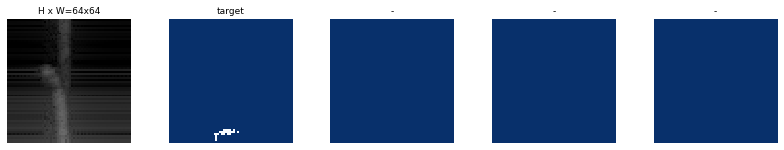

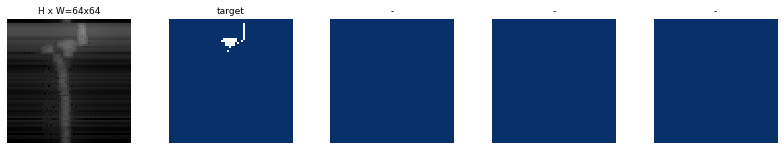

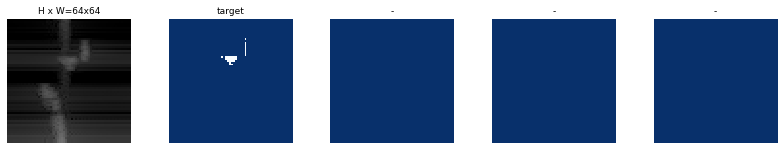

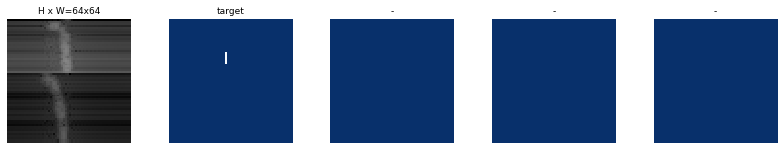

In [9]:
# Load and display train image and mask samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

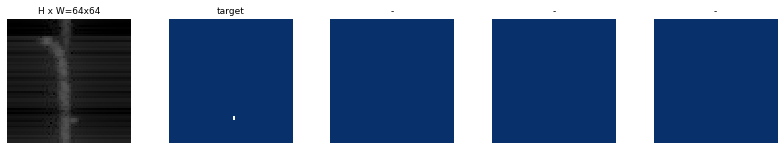

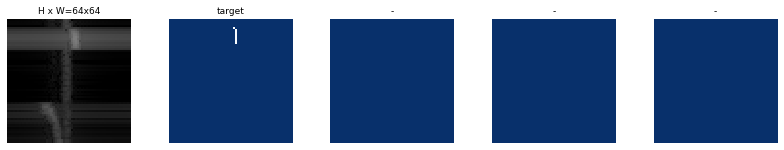

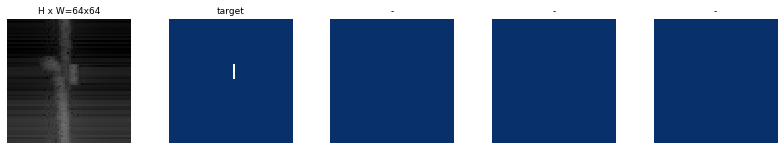

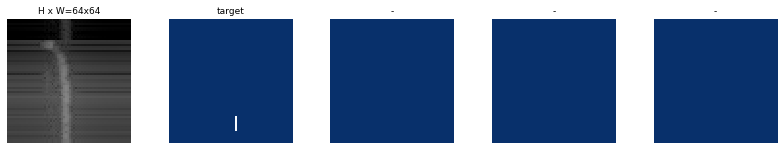

In [10]:
# Load and display test image and mask samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

## Create Model

In [11]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

W0809 12:40:31.027424 140293405153088 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 12:40:31.050095 140293405153088 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 12:40:31.233099 140293405153088 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 12:40:31.255640 140293405153088 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please us

In [12]:
# Load last model trained and continue training
# model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/admin/dev/SonarNet/logs/sonar20190809T1240/mask_rcnn_sonar_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

W0809 12:40:57.637980 140293405153088 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 1/1
100/100 [==============================] - 465s 5s/step - loss: 8.7062 - rpn_class_loss: 0.3856 - rpn_bbox_loss: 6.8604 - mrcnn_class_loss: 0.2826 - mrcnn_bbox_loss: 1.0632 - mrcnn_mask_loss: 0.1144 - val_loss: 13.0632 - val_rpn_class_loss: 0.1317 - val_rpn_bbox_loss: 11.2262 - val_mrcnn_class_loss: 0.0994 - val_mrcnn_bbox_loss: 1.1887 - val_mrcnn_mask_loss: 0.4172


In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/admin/dev/SonarNet/logs/sonar20190809T1240/mask_rcnn_sonar_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWa

Epoch 2/2
100/100 [==============================] - 516s 5s/step - loss: 3.0149 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 1.9934 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.6264 - mrcnn_mask_loss: 0.2404 - val_loss: 8.9167 - val_rpn_class_loss: 0.1044 - val_rpn_bbox_loss: 8.2944 - val_mrcnn_class_loss: 0.0082 - val_mrcnn_bbox_loss: 0.3363 - val_mrcnn_mask_loss: 0.1733


## Detection

In [16]:
class InferenceConfig(SonarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0805 14:18:59.499900 139858852153152 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0805 14:18:59.625472 139858852153152 deprecation.py:323] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /home/admin/dev/SonarNet/logs/sonar20190805T1354/mask_rcnn_sonar_0002.h5
Re-starting from epoch 2


original_image           shape: (64, 64, 3)           min:    0.00000  max:  112.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1588.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:   17.00000  max:   39.00000  int32
gt_mask                  shape: (64, 64, 1)           min:    0.00000  max:    1.00000  bool


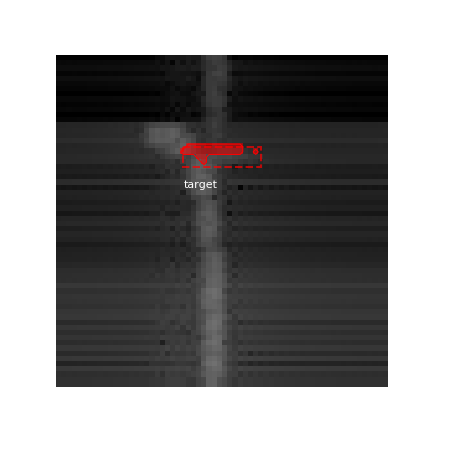

In [17]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  112.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:    8.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -0.71833  max:    0.98140  float32


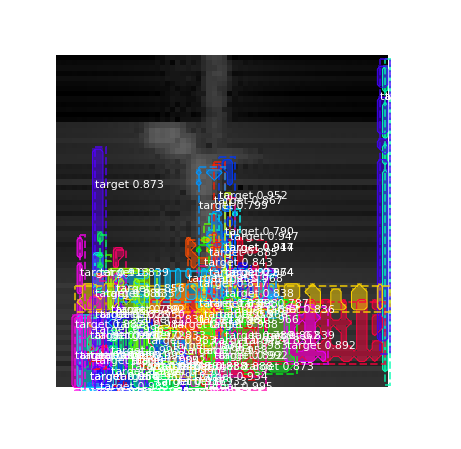

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP(mean average precision) @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


---

### 3D image slicing

In [24]:
# %matplotlib inline      # turn interactive off
%matplotlib notebook  # turn interactive on

UsageError: unrecognized arguments: # turn interactive on


(code from 3d mri tutorial)

In [22]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

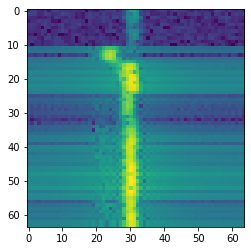

In [32]:
test_image_zxy, test_label = [], dataset_train.image_info[0*24]["mask"]
for i in range(25):
    test_image_zxy.append(dataset_train.image_info[i]["image"][:,:,0])
test_image_zxy, test_label = np.array(test_image_zxy), np.array(test_label).astype(np.float)

multi_slice_viewer(test_image_zxy)

### 3d plot

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [34]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, normed=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=cube.shape[0]*2)
    ax.set_ylim(top=cube.shape[1]*2)
    ax.set_zlim(top=cube.shape[2]*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()

In [35]:
# Convert from 25x64x64 to 64x64x25
test_image_xyz = np.zeros((64,64,25))
for i in range(25):
    test_image_xyz[:,:,i] = test_image_zxy[i,:,:]

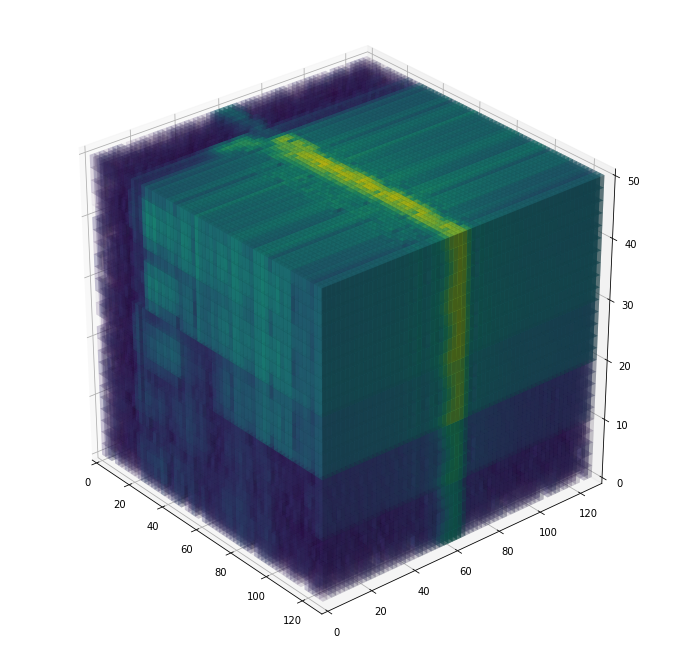

In [36]:
# Plot sonar
plot_cube(test_image_xyz)

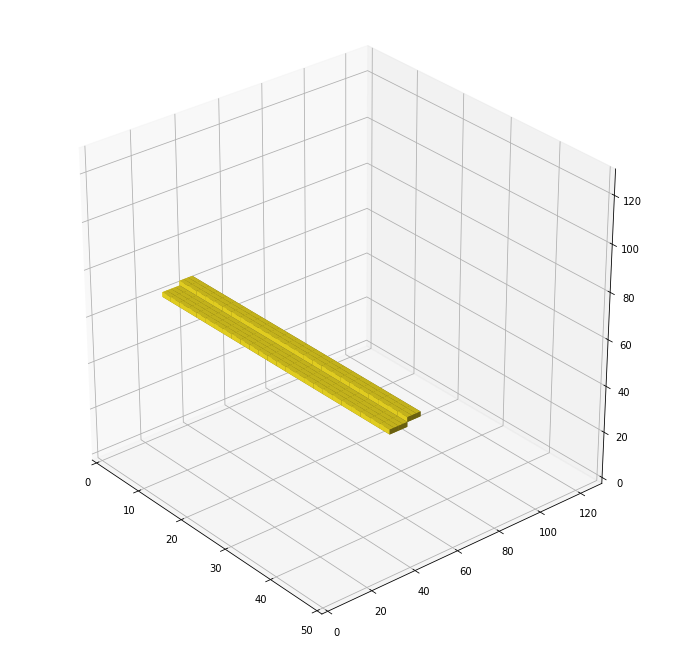

In [37]:
# Plot sonar label
test_label.shape = (64, 64)
plot_cube(np.tile(test_label, (25, 1, 1)))

---

## Test code

In [ ]:

# Get image of size 25x64x64
            img = np.fromfile(DATA_PATH + 'ImageMap-' + str(id) + '.dat',
                       dtype='uint8')
#             img = img.reshape((25,64,64))
            
            # Convert from 25x64x64 to 64x64x25
#             img_xyz = np.zeros((64,64,25))
#             for i in range(img.shape[0]):
#                 img_xyz[:,:,i] = img[i,:,:]
            
#             img = img_xyz
            # Convert image from [height, width] to [height, width, 3]
#             img = skimage.color.gray2rgb(img)
            # Note - Match label dimensions with inputs by copying a 64x64 label side by side 
            #        into a 320x320 label
            mask = np.fromfile(DATA_PATH + 'LabelMap-' + str(id) + '.dat',
                       dtype='uint8')
            mask.shape = (64, 64)
#             mask_ext = np.array(mask, copy=True)

            # Horizontal extension 
#             for _ in range(int(320/64) - 1):
#                 mask_ext = np.hstack((mask_ext, mask))

            # Vertical extension
#             horz_copy = np.array(mask_ext, copy=True)
#             for _ in range(int(320/64) - 1):
#                 mask_ext = np.vstack((mask_ext, horz_copy))
            
            # Convert to bool array and reshape for desired output
            # TODO: fix hardcode
#             mask = mask_ext.astype(np.bool).reshape((320,320,1))


In [ ]:
# Since we need a flat image, convert 64x64x25 to 64x1600 (64x64 side by side 25 times)
test_big = test_image_xyz.swapaxes(0,1).reshape(64,1600)

# Then convert 64x1600 to 320x320
# test_image_xyz_square = np,zeros()
plt.imshow(test_image_xyz[:,:,0])
plt.show()

plt.imshow(test_big[:,:64])
plt.show()

In [ ]:
# Display example slice
# Input: 25 slices of sonar beam
for i in range(25):
    plt.imshow(test_image_xyz[:,:,i])
    plt.show()

In [ ]:
# Label: target detection
plt.imshow(test_label)

In [ ]:
# Convert from 25x64x64 to 64x64x25
test_image_xyz = np.zeros((64,64,25))
for i in range(25):
    test_image_xyz[:,:,i] = test_image_zxy[i,:,:]

Credit:

[1] https://github.com/matterport/Mask_RCNN/samples/shapes/train_shapes.ipynb
